In [1]:
import numpy as np
import os

os.environ["KERAS_BACKEND"] = "torch"

In [2]:
import keras
import torch
import matplotlib.pyplot as plt

In [3]:
keras.utils.get_file(
    "ridership.tgz", "https://github.com/ageron/data/raw/main/ridership.tgz", cache_dir=".", extract=True
)

'./datasets/ridership.tgz'

In [4]:
import pandas as pd
from pathlib import Path

path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

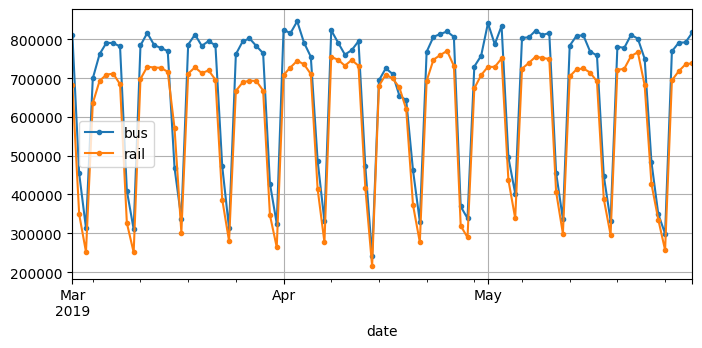

In [5]:
df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

In [6]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [7]:
seq_length = 56
train_ds = keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42,
)
valid_ds = keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(), targets=rail_valid[seq_length:], sequence_length=seq_length, batch_size=32
)

2024-08-21 15:45:03.475256: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-21 15:45:03.482822: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 15:45:03.496304: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 15:45:03.499951: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-21 15:45:03.511138: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instru

In [8]:
model = keras.Sequential([keras.layers.Dense(1, input_shape=[seq_length])])
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)
opt = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500, callbacks=[early_stopping_cb])

/home/christian/projects/ml/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1009 - mae: 0.3477 - val_loss: 0.0183 - val_mae: 0.1601
Epoch 2/500
20/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0227 - mae: 0.1700

2024-08-21 15:45:09.220121: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-21 15:45:09.260209: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0211 - mae: 0.1629 - val_loss: 0.0111 - val_mae: 0.1224
Epoch 3/500
16/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0127 - mae: 0.1235

2024-08-21 15:45:09.557273: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0125 - mae: 0.1222 - val_loss: 0.0106 - val_mae: 0.1206
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0108 - mae: 0.1135 - val_loss: 0.0082 - val_mae: 0.1039
Epoch 5/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0100 - mae: 0.1084

2024-08-21 15:45:10.133648: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0098 - mae: 0.1073 - val_loss: 0.0065 - val_mae: 0.0911
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0085 - mae: 0.0983 - val_loss: 0.0058 - val_mae: 0.0851
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0074 - mae: 0.0893 - val_loss: 0.0053 - val_mae: 0.0805
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068 - mae: 0.0865 - val_loss: 0.0049 - val_mae: 0.0773
Epoch 9/500
22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0059 - mae: 0.0820

2024-08-21 15:45:11.205808: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0060 - mae: 0.0820 - val_loss: 0.0042 - val_mae: 0.0697
Epoch 10/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0058 - mae: 0.0778 - val_loss: 0.0054 - val_mae: 0.0807
Epoch 11/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0064 - mae: 0.0862 - val_loss: 0.0048 - val_mae: 0.0774
Epoch 12/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0057 - mae: 0.0765 - val_loss: 0.0035 - val_mae: 0.0615
Epoch 13/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - mae: 0.0701 - val_loss: 0.0038 - val_mae: 0.0662
Epoch 14/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0045 - mae: 0.0671 - val_loss: 0.0032 - val_mae: 0.0581
Epoch 15/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042 - mae: 0.0673 - val_loss: 0.0036 - val_mae: 0.0642
Epoch 16/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0048 - mae: 0.0666 - val_loss: 0.0030 - val_mae: 0.0551
Epoch 17/500
15/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0044 - 

2024-08-21 15:45:13.541471: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0045 - mae: 0.0683 - val_loss: 0.0032 - val_mae: 0.0585
Epoch 18/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044 - mae: 0.0651 - val_loss: 0.0029 - val_mae: 0.0552
Epoch 19/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041 - mae: 0.0610 - val_loss: 0.0028 - val_mae: 0.0523
Epoch 20/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041 - mae: 0.0627 - val_loss: 0.0028 - val_mae: 0.0523
Epoch 21/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042 - mae: 0.0601 - val_loss: 0.0028 - val_mae: 0.0521
Epoch 22/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043 - mae: 0.0622 - val_loss: 0.0030 - val_mae: 0.0571
Epoch 23/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044 - mae: 0.0633 - val_loss: 0.0027 - val_mae: 0.0517
Epoch 24/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0038 - mae: 0.0588 - val_loss: 0.0026 - val_mae: 0.0509
Epoch 25/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040 - 

2024-08-21 15:45:17.844498: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0039 - mae: 0.0577 - val_loss: 0.0024 - val_mae: 0.0468
Epoch 34/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0523 - val_loss: 0.0023 - val_mae: 0.0457
Epoch 35/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mae: 0.0552 - val_loss: 0.0024 - val_mae: 0.0465
Epoch 36/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - mae: 0.0544 - val_loss: 0.0023 - val_mae: 0.0460
Epoch 37/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - mae: 0.0506 - val_loss: 0.0024 - val_mae: 0.0456
Epoch 38/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - mae: 0.0537 - val_loss: 0.0023 - val_mae: 0.0445
Epoch 39/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - mae: 0.0503 - val_loss: 0.0023 - val_mae: 0.0457
Epoch 40/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0031 - mae: 0.0516 - val_loss: 0.0028 - val_mae: 0.0502
Epoch 41/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0031 - 

2024-08-21 15:45:27.660028: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - mae: 0.0621 - val_loss: 0.0029 - val_mae: 0.0562
Epoch 66/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029 - mae: 0.0487 - val_loss: 0.0025 - val_mae: 0.0445
Epoch 67/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0487 - val_loss: 0.0024 - val_mae: 0.0430
Epoch 68/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0475 - val_loss: 0.0022 - val_mae: 0.0403
Epoch 69/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mae: 0.0454 - val_loss: 0.0022 - val_mae: 0.0401
Epoch 70/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mae: 0.0480 - val_loss: 0.0023 - val_mae: 0.0438
Epoch 71/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mae: 0.0449 - val_loss: 0.0022 - val_mae: 0.0402
Epoch 72/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0462 - val_loss: 0.0022 - val_mae: 0.0398
Epoch 73/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034 - 

2024-08-21 15:45:48.622467: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mae: 0.0457 - val_loss: 0.0031 - val_mae: 0.0513
Epoch 130/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0510 - val_loss: 0.0022 - val_mae: 0.0388
Epoch 131/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0460 - val_loss: 0.0022 - val_mae: 0.0382
Epoch 132/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027 - mae: 0.0451 - val_loss: 0.0022 - val_mae: 0.0383
Epoch 133/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - mae: 0.0441 - val_loss: 0.0023 - val_mae: 0.0409
Epoch 134/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028 - mae: 0.0431 - val_loss: 0.0022 - val_mae: 0.0382
Epoch 135/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - mae: 0.0467 - val_loss: 0.0023 - val_mae: 0.0421
Epoch 136/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - mae: 0.0445 - val_loss: 0.0024 - val_mae: 0.0397
Epoch 137/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 

2024-08-21 15:46:26.291261: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0463 - val_loss: 0.0022 - val_mae: 0.0380
Epoch 258/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mae: 0.0422 - val_loss: 0.0023 - val_mae: 0.0379
Epoch 259/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0466 - val_loss: 0.0023 - val_mae: 0.0376
Epoch 260/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - mae: 0.0463 - val_loss: 0.0030 - val_mae: 0.0575
Epoch 261/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0550 - val_loss: 0.0026 - val_mae: 0.0431
Epoch 262/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - mae: 0.0505 - val_loss: 0.0022 - val_mae: 0.0379
Epoch 263/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0033 - mae: 0.0456 - val_loss: 0.0023 - val_mae: 0.0377
Epoch 264/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - mae: 0.0480 - val_loss: 0.0026 - val_mae: 0.0477
Epoch 265/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 

In [9]:
# extra code – evaluates the model
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019 - mae: 0.0386 


37358.78691077232

In [10]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    es_cb = keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)
    opt = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs, callbacks=[es_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [11]:
simple_rnn_model = keras.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500


/home/christian/projects/ml/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0462 - val_loss: 0.0024 - val_mae: 0.0387
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - mae: 0.0473 - val_loss: 0.0023 - val_mae: 0.0378
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mae: 0.0445 - val_loss: 0.0027 - val_mae: 0.0515
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - mae: 0.0460 - val_loss: 0.0023 - val_mae: 0.0382
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - mae: 0.0444 - val_loss: 0.0028 - val_mae: 0.0461
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - mae: 0.0516 - val_loss: 0.0024 - val_mae: 0.0422
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mae: 0.0427 - val_loss: 0.0025 - val_mae: 0.0450
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - mae: 0.0488 - val_loss: 0.0031 - val_mae: 0.0522
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.

37757.374346256256

In [12]:
deep_model = keras.Sequential([
    # First SimpleRNN layer: sequence-to-sequence
    # 32 units, returns sequences for next layer, input shape is [None, 1]
    # None allows variable sequence length, 1 is for single feature
    keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    
    # Second SimpleRNN layer: sequence-to-sequence
    # 32 units, returns sequences for next layer
    keras.layers.SimpleRNN(32, return_sequences=True),
    
    # Third SimpleRNN layer: sequence-to-vector
    # 32 units, does not return sequences (only last output)
    keras.layers.SimpleRNN(32),
    
    # Final Dense layer
    # 1 unit for single output prediction
    keras.layers.Dense(1)
])
# This model architecture allows for processing sequences,
# extracting features through multiple RNN layers,
# and making a final prediction with the Dense layer

fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

/home/christian/projects/ml/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 0.1251 - mae: 0.3895 - val_loss: 0.0062 - val_mae: 0.0881
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 0.0062 - mae: 0.0811 - val_loss: 0.0025 - val_mae: 0.0472
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - loss: 0.0058 - mae: 0.0763 - val_loss: 0.0042 - val_mae: 0.0707
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - loss: 0.0049 - mae: 0.0674 - val_loss: 0.0021 - val_mae: 0.0428
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 0.0042 - mae: 0.0617 - val_loss: 0.0028 - val_mae: 0.0523
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.0041 - mae: 0.0599 - val_loss: 0.0027 - val_mae: 0.0487
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.0036 - mae: 0.0554 - val_loss: 0.0021 - val_mae: 0.0374
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - loss: 0.0037 - mae: 0.0543 - val_loss: 0.0019 - val_mae: 0.0347
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/

28764.918446540833

## Multivariate

In [15]:
df_mulvar = df[["bus", "rail"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar)  # one-hot encode the day type

In [16]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [24]:
train_mulvar_ds = keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),  # use all 5 columns as input
    targets=mulvar_train["rail"][seq_length:],  # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [20]:
mulvar_model = keras.Sequential([
    keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    keras.layers.Dense(1)
])

/home/christian/projects/ml/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
fit_and_evaluate(
    mulvar_model, train_mulvar_ds, valid_mulvar_ds, learning_rate=0.05
)

NameError: name 'train_mulvar_ds' is not defined

In [8]:
import numpy as np

class SimpleRNN:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # Initialize weights
        self.Wxh = np.random.randn(hidden_size, input_size) * 0.01
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.01
        self.Why = np.random.randn(output_size, hidden_size) * 0.01
        
        # Initialize biases
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))
    
    def forward(self, inputs):
        h = np.zeros((self.hidden_size, 1))
        self.last_inputs = inputs
        self.last_hs = { 0: h }
        
        # Perform forward pass
        for i, x in enumerate(inputs):
            print(i, x)
            h = np.tanh(np.dot(self.Wxh, x) + np.dot(self.Whh, h) + self.bh)
            self.last_hs[i + 1] = h
        
        # Compute the output
        y = np.dot(self.Why, h) + self.by
        return y, h
    
    def backward(self, d_y, learn_rate=2e-2):
        n = len(self.last_inputs)
        
        # Calculate dL/dWhy and dL/dby
        d_Why = np.dot(d_y, self.last_hs[n].T)
        d_by = d_y
        
        # Initialize dL/dWhh, dL/dWxh, and dL/dbh
        d_Whh = np.zeros(self.Whh.shape)
        d_Wxh = np.zeros(self.Wxh.shape)
        d_bh = np.zeros(self.bh.shape)
        
        # Initialize dL/dh for the last time step
        d_h = np.dot(self.Why.T, d_y)
        
        # Backpropagate through time
        for t in reversed(range(n)):
            # Backprop through tanh
            temp = ((1 - self.last_hs[t+1] ** 2) * d_h)
            
            # Calculate dL/dWhh
            d_Whh += np.dot(temp, self.last_hs[t].T)
            
            # Calculate dL/dWxh
            d_Wxh += np.dot(temp, self.last_inputs[t].T)
            
            # Calculate dL/dbh
            d_bh += temp
            
            # Calculate dL/dh for the next iteration
            d_h = np.dot(self.Whh.T, temp)
        
        # Clip to prevent exploding gradients
        for d in [d_Wxh, d_Whh, d_Why, d_bh, d_by]:
            np.clip(d, -1, 1, out=d)
        
        # Update weights and biases
        self.Whh -= learn_rate * d_Whh
        self.Wxh -= learn_rate * d_Wxh
        self.Why -= learn_rate * d_Why
        self.bh -= learn_rate * d_bh
        self.by -= learn_rate * d_by

# Example usage
input_size = 3
hidden_size = 4
output_size = 2

rnn = SimpleRNN(input_size, hidden_size, output_size)

# Sample input sequence
inputs = [np.random.randn(input_size, 1) for _ in range(5)]
print(np.array(inputs).shape)

# Forward pass
output, hidden = rnn.forward(inputs)

# Backward pass (assuming some loss function gave us d_y)
d_y = np.random.randn(output_size, 1)
rnn.backward(d_y)

print("Output shape:", output.shape)
print("Hidden state shape:", hidden.shape)

(5, 3, 1)
0 [[0.83094525]
 [0.72904262]
 [1.10165534]]
1 [[ 1.31599132]
 [-1.57327728]
 [ 0.04593858]]
2 [[0.08802191]
 [1.1917449 ]
 [0.74013772]]
3 [[0.36494742]
 [0.5176061 ]
 [0.63079118]]
4 [[ 0.00179505]
 [-0.61169081]
 [-1.67195378]]
Output shape: (2, 1)
Hidden state shape: (4, 1)
